In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)

2.5.0


In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# 参数 num_words=10000 保留了训练数据中最常出现的 10,000 个单词。为了保持数据规模的可管理性，低频词将被丢弃。

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\program\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
D:\program\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'd

## 数据预处理

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])
print(len(train_data[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218


In [5]:
# 将整数转换回单词
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [6]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据
### 影评——即整数数组必须在输入神经网络之前转换为张量。这种转换可以通过以下两种方式来完成：
+ 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 num_words * num_reviews 的矩阵。
+ 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 max_length * num_reviews 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。



In [7]:
# 使用pad_sequence函数使序列填充到相同长度
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [8]:
len(train_data[0]),len(train_data[1])

(256, 256)

In [9]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 构建模型
+ 模型有多少层？
+ 每层中有多少隐层单元（hidden units）

In [10]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
# 该层采用整数编码的词汇表，并查找每个词索引的嵌入向量，向量向输出数组增加了一个维度
model.add(keras.layers.GlobalAveragePooling1D())
# 对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
model.add(keras.layers.Dense(16,activation='relu'))
# 有 16 个隐层单元的全连接层传输
model.add(keras.layers.Dense(1,activation='sigmoid'))
# 最后一层与单个输出结点密集连接，使用sigmoid函数，其函数值表示概率或置信度

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 配置优化器和损失函数
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
# 创建验证集

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 训练模型

In [17]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=40, # 迭代40次
    batch_size=512 , #512个样本
    validation_data=(x_val,y_val),
    verbose=1
)

Epoch 1/40
30/30 [==============================] - 2s 34ms/step - loss: 0.6917 - accuracy: 0.5109 - val_loss: 0.6896 - val_accuracy: 0.5595
Epoch 2/40
30/30 [==============================] - 1s 26ms/step - loss: 0.6848 - accuracy: 0.6270 - val_loss: 0.6799 - val_accuracy: 0.6853
Epoch 3/40
30/30 [==============================] - 1s 27ms/step - loss: 0.6700 - accuracy: 0.7272 - val_loss: 0.6622 - val_accuracy: 0.7263
Epoch 4/40
30/30 [==============================] - 1s 25ms/step - loss: 0.6451 - accuracy: 0.7501 - val_loss: 0.6344 - val_accuracy: 0.7559
Epoch 5/40
30/30 [==============================] - 1s 25ms/step - loss: 0.6097 - accuracy: 0.7879 - val_loss: 0.5982 - val_accuracy: 0.7811
Epoch 6/40
30/30 [==============================] - 1s 29ms/step - loss: 0.5660 - accuracy: 0.8132 - val_loss: 0.5564 - val_accuracy: 0.8064
Epoch 7/40
30/30 [==============================] - 1s 27ms/step - loss: 0.5186 - accuracy: 0.8349 - val_loss: 0.5122 - val_accuracy: 0.8240
Epoch 8/40
30

## 评估模型

In [18]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

782/782 - 1s - loss: 0.3351 - accuracy: 0.8700
[0.3351227641105652, 0.8700000047683716]


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

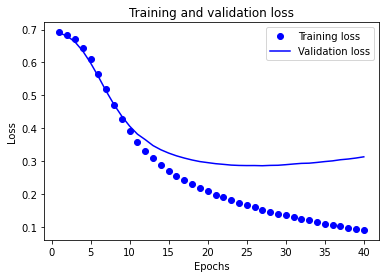

In [22]:
import matplotlib.pyplot as plt 

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()  # 图中可看出，本次预测出现了过拟合

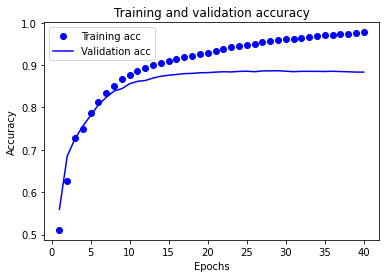

In [23]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()